In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
os.chdir('/Users/younghun/Desktop/gitrepo/data')
warnings.filterwarnings(action='ignore')

# Data preprocessing

In [6]:
house_df_org = pd.read_csv('house_train.csv', encoding='utf-8')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [7]:
print(house_df.shape)

(1460, 81)


In [9]:
house_df.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [12]:
# 칼럼별 결측치 구한 값들은 Series로 반환되기 때문에 이를 boolean index로 취급해서
# 결측치가 있는 변수들이 무엇인지 보기
isnull_series = house_df.isnull().sum()
isnull_series[isnull_series > 0].sort_values(ascending=False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

<AxesSubplot:title={'center':'Original SalePrice Distribution'}, xlabel='SalePrice'>

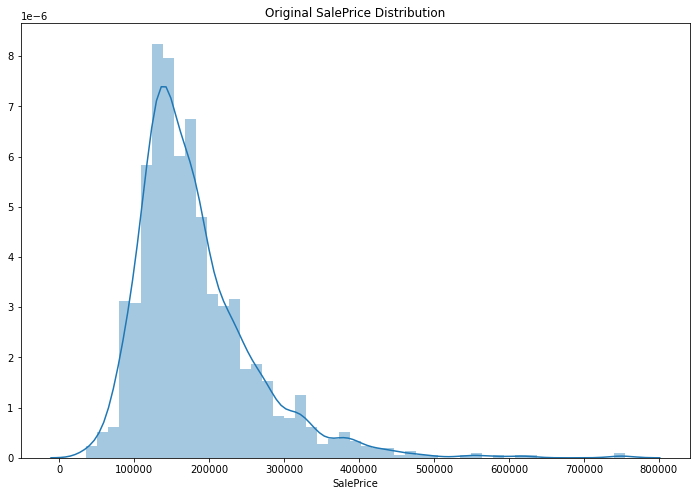

In [18]:
# 종속변수인 SalesPrice의 분포도 살펴보기
plt.figure(figsize=(12,8))
plt.title('Original SalePrice Distribution')
sns.distplot(house_df['SalePrice'])

<AxesSubplot:title={'center':'Distribution of log SalePrice'}, xlabel='SalePrice'>

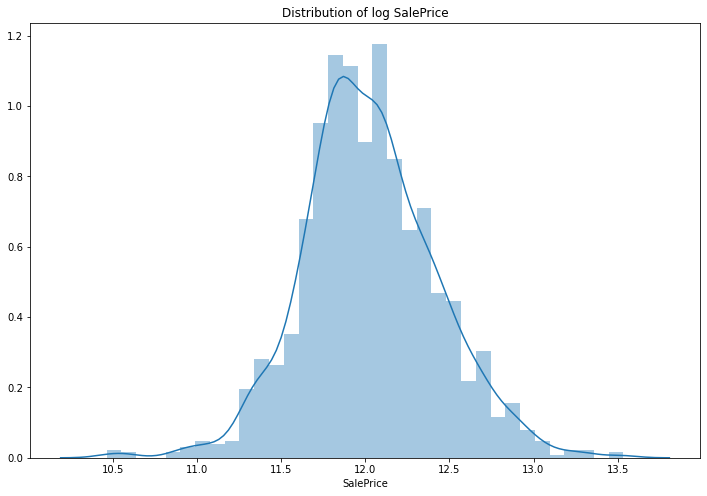

In [19]:
# log값을 취해서 편향된 분포에서 정규분포로 바꾸어주기
log_sales = np.log1p(house_df['SalePrice'])
plt.figure(figsize=(12,8))
plt.title('Distribution of log SalePrice')
sns.distplot(log_sales)

In [20]:
# log값 취해진 SalePrice로 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# 필요없는 변수 삭제
ncols = ['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu']
house_df = house_df.drop(ncols, axis=1, inplace=False)
# 수치형 변수의 결측치값은 평균값으로 대체하기
house_df = house_df.fillna(house_df.mean())

In [29]:
#결측치가 있는 변수명과 타입 추출
# Series로 반환됨
null_column = house_df.isnull().sum()[house_df.isnull().sum() > 0]
# 결측치가 존재하는 변수의 type확인하기
house_df.dtypes[null_column.index]

MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object

**중요) 회귀분석에서 범주형 변수 인코딩은 레이블인코딩보다 원-핫 인코딩이 성능 향상에 도움!**

In [30]:
# pandas의 get_dummies이용
# get_dummise가 자동으로 범주형볌수를 인식함!
house_df_ohe = pd.get_dummies(house_df)

In [32]:
# 잘 인코딩 됬는지 확인
print("원본 데이터셋", house_df.shape)
print("원-핫 인코딩 후 데이터셋", house_df_ohe.shape)

원본 데이터셋 (1460, 75)
원-핫 인코딩 후 데이터셋 (1460, 271)


# Linear regression modeling

In [33]:
from sklearn.metrics import mean_squared_error

def get_rmse(model):
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"{model.__class__.__name__} 로그 변환된 RMSE :{rmse:.4f}")
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

y_target = house_df_ohe['SalePrice']
x_feature = house_df_ohe.drop(['SalePrice'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x_feature,
                                                   y_target,
                                                   test_size=0.3,
                                                   random_state=2)
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)

rid_reg = Ridge()
rid_reg.fit(x_train, y_train)

las_reg = Lasso()
las_reg.fit(x_train, y_train)

models = [lr_reg, rid_reg, las_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE :943.3948
Ridge 로그 변환된 RMSE :0.2063
Lasso 로그 변환된 RMSE :0.2737


[943.3947517495966, 0.20631673113058438, 0.2737177585374857]

In [38]:
len(lr_reg.coef_)

270

In [39]:
# 칼럼별로 회귀계수를 시각화 하기 위해 회귀계수 상,하위 일부 추출
def get_top_botoom_coef(model):
    coef = pd.Series(model.coef_, index=x_feature.columns)
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

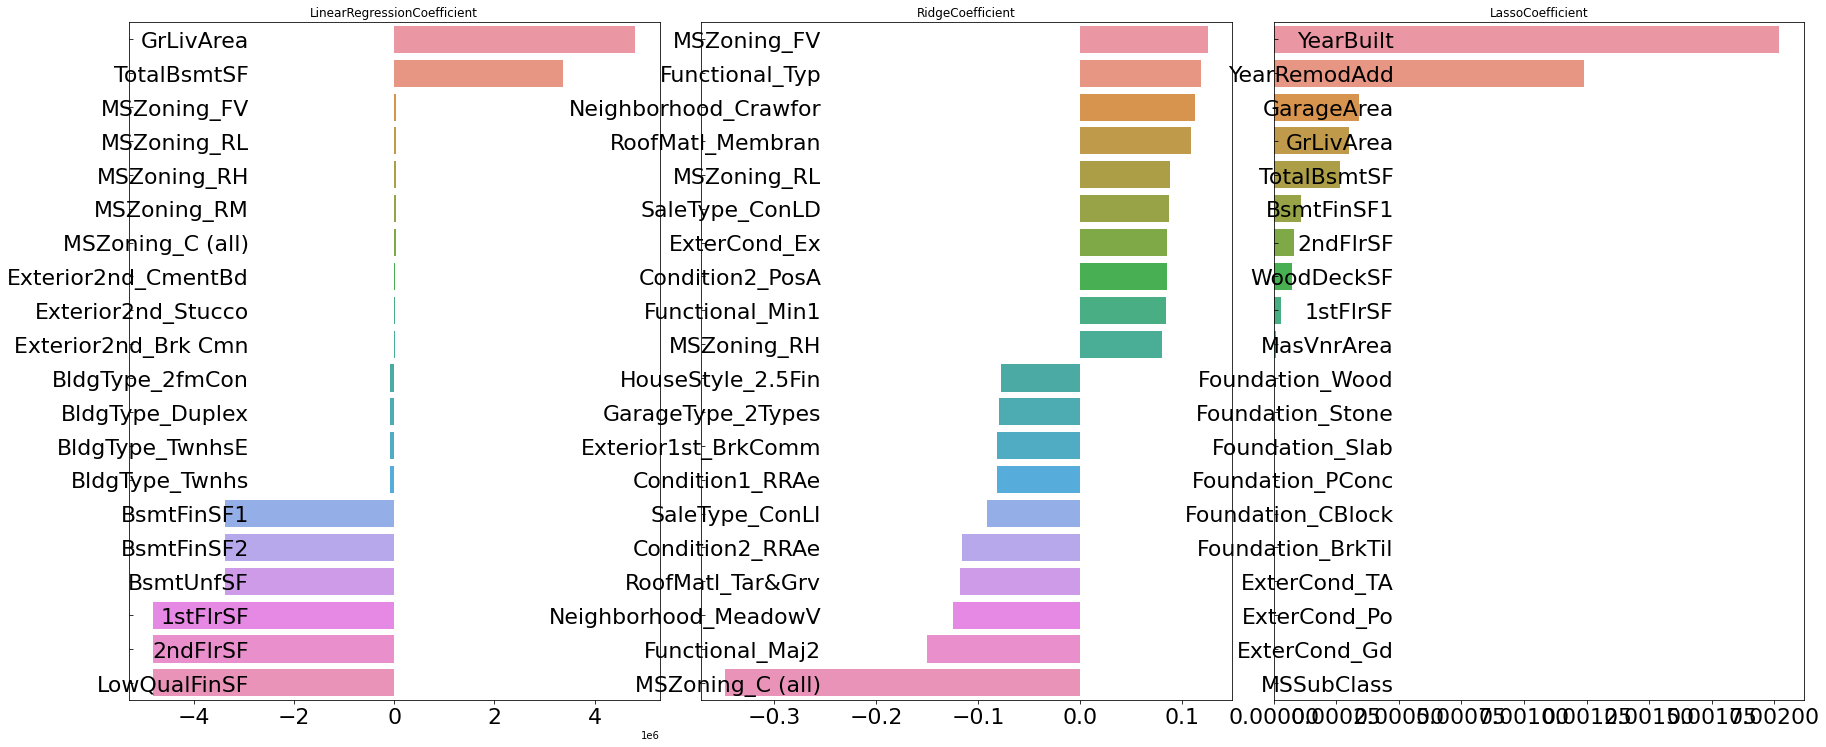

In [41]:
# 위에서 추출한 회귀계수들 시각화
def visualize_coef(models):
    fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=3)
    fig.tight_layout()
    
    for ax_num, model in enumerate(models):
        coef_high, coef_low = get_top_botoom_coef(model)
        coef_df = pd.concat([coef_high, coef_low], axis=0)
        
        axs[ax_num].set_title(model.__class__.__name__+'Coefficient')
        # y축 파라미터의 값들을 안쪽으로 해주도록 설정
        # pad: tick와 label 사이의 간격
        axs[ax_num].tick_params(axis='y', direction='in', pad=-120)
        # 각 subplot에다가 x축, y축에다가 label 붙이기
        for label in (axs[ax_num].get_xticklabels() + axs[ax_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_df.values, y=coef_df.index, ax=axs[ax_num])

models = [lr_reg, rid_reg, las_reg]
visualize_coef(models)

In [43]:
# cross_val_score이용해서 테스트데이터로 교차검증 후 평균 RMSE 도출
from sklearn.model_selection import cross_val_score
def get_avg_rmse_cv(models):
    for model in models:
        neg_mse = cross_val_score(model, x_feature, y_target,
                                  scoring='neg_mean_squared_error',
                                  cv=5)
        rmse = np.sqrt(-1*neg_mse)
        avg_rmse = np.mean(rmse)
        print(f"{model.__class__.__name__}의 각 fold RMSE\n{rmse}")
        print(f"{model.__class__.__name__}의 평균 RMSE:{avg_rmse:.4f}")

models = [lr_reg, rid_reg, las_reg]
get_avg_rmse_cv(models)

LinearRegression의 각 fold RMSE
[0.13532312 0.16457906 0.167651   0.11089677 0.19808115]
LinearRegression의 평균 RMSE:0.1553
Ridge의 각 fold RMSE
[0.11725334 0.15439419 0.14208945 0.11652709 0.18898702]
Ridge의 평균 RMSE:0.1439
Lasso의 각 fold RMSE
[0.16077499 0.20437243 0.17676683 0.18127643 0.2651206 ]
Lasso의 평균 RMSE:0.1977


In [75]:
# GridSearchCV이용해서 교차검증하면서 하이퍼 파라미터 튜닝하기
from sklearn.model_selection import GridSearchCV

def get_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                             scoring='neg_mean_squared_error',
                             cv=5)
    # 학습시켜줄 때는 학습데이터들로 학습시키기
    grid_model.fit(x_train, y_train)
    # 최적의 estimator로 학습/검증한 상태임!
    rmse_lst = np.sqrt(-1*grid_model.best_score_)
    avg_rmse = np.mean(rmse_lst)
    print(f"{model.__class__.__name__} 교차검증 후 최고 평균 RMSE:{avg_rmse:.4f}\n최적의 파라미터값:{grid_model.best_params_}")
    return grid_model.best_estimator_

In [47]:
ridge_params = {'alpha':[0.1, 1, 5, 10, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.05, 0.03, 0.1]}
best_ridge = get_best_params(rid_reg, ridge_params)
best_lasso = get_best_params(las_reg, lasso_params)

Ridge 교차검증 후 최고 평균 RMSE:0.1170
최적의 파라미터값:{'alpha': 20}
Lasso 교차검증 후 최고 평균 RMSE:0.1156
최적의 파라미터값:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE :943.3948
Ridge 로그 변환된 RMSE :0.2074
Lasso 로그 변환된 RMSE :0.2063


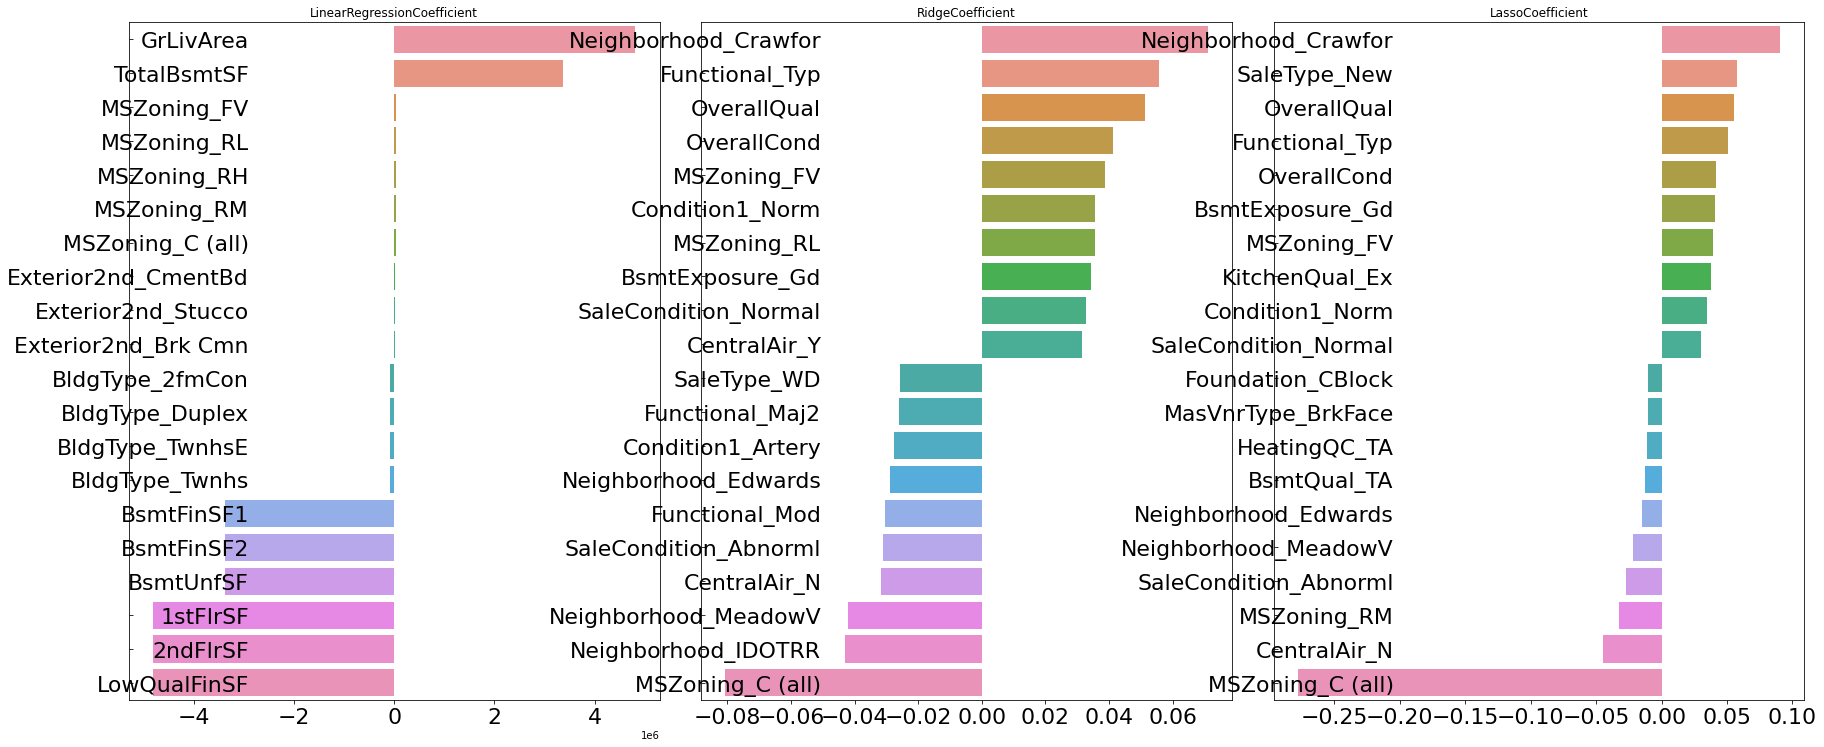

In [50]:
# 알아낸 최적의 파라미터로 x_train으로 학습하고 x_test로 평가해보기
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)

rid_reg = Ridge(alpha=20)
rid_reg.fit(x_train, y_train)

las_reg = Lasso(alpha=0.001)
las_reg.fit(x_train, y_train)

models = [lr_reg, rid_reg, las_reg]
# 테스트 데이터로 평가후 RMSE출력하는 get_rmses함수 이용해 평가
get_rmses(models)
visualize_coef(models)

# Feature engineering

In [55]:
# feature들에 대한 분포 편향도를 확인하고 높은 왜곡도를 갖는 feature 추출
# Scipy의 skew함수를 통해서 첨도 수치로 표시해서 왜곡도 추론 가능
from scipy.stats import skew
# skew(첨도) 출력 함수는 수치형 변수에만 적용되기 때문에 수치형 변수들만 골라내기
numeric_features = house_df.dtypes[house_df.dtypes != 'object'].index
# Series형태로 반환
skew_features = house_df[numeric_features].apply(lambda x: skew(x))
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [58]:
# 첨도 수치가 1이상인 feature들에 대해서 log값으로 변환해주기
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [59]:
# 수치형변수들을 Log값으로 취한 후의 데이터에서 범주형 변수 재 원-핫인코딩해주기
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
x_feature = house_df_ohe.drop('SalePrice', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_feature,
                                                   y_target,
                                                   test_size=0.3,
                                                   random_state=42)
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = get_best_params(rid_reg, ridge_params)
best_lasso = get_best_params(las_reg, lasso_params)

Ridge 교차검증 후 최고 평균 RMSE:0.1408
최적의 파라미터값:{'alpha': 20}
Lasso 교차검증 후 최고 평균 RMSE:0.1403
최적의 파라미터값:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE :0.1260
Ridge 로그 변환된 RMSE :0.1272
Lasso 로그 변환된 RMSE :0.1242


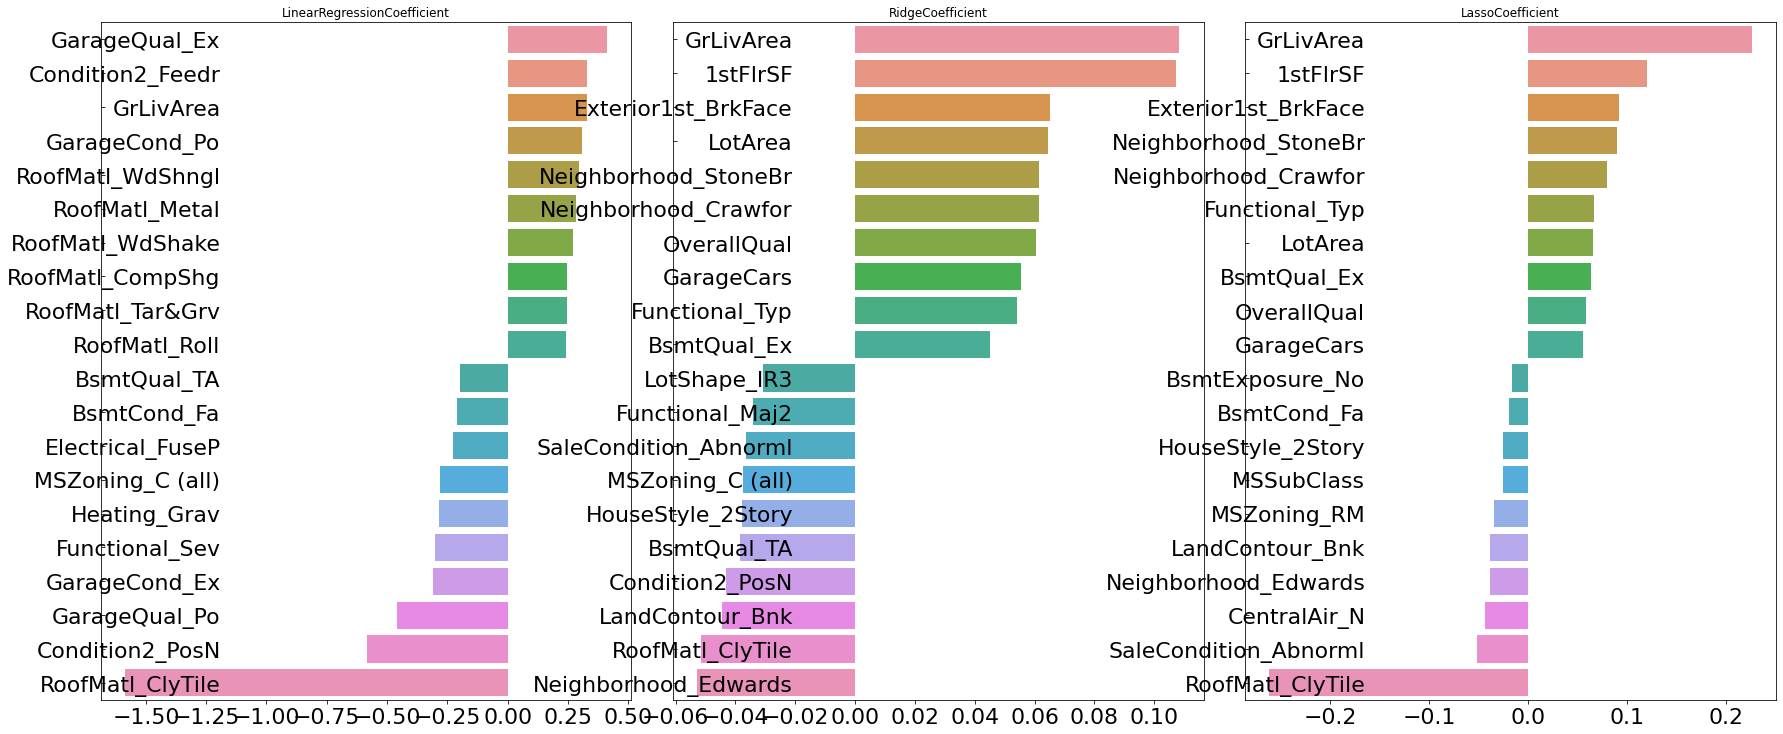

In [60]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
rid_reg = Ridge(alpha=20)
rid_reg.fit(x_train, y_train)
las_reg = Lasso(alpha=0.001)
las_reg.fit(x_train, y_train)

models = [lr_reg, rid_reg, las_reg]
get_rmses(models)

visualize_coef(models)

Text(0.5, 0, 'GrLivArea')

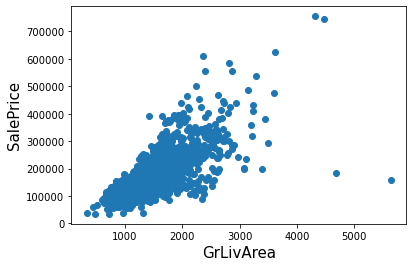

In [61]:
# 위에서 시각화한 feature들 중 GrLivArea가 많은 영향을 끼치기 때문에
# 해당 변수에 대한 이상치 살펴보기
# 이상치 살펴보기 위해서 산점도 그려보기
plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)

In [62]:
# 위 산점도를 보고 이상치 범위에 존재하는 데이터 제외한 데이터 저장
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_idx = house_df_ohe[cond1 & cond2].index

house_df_ohe = house_df_ohe.drop(outlier_idx, axis=0)

In [63]:
y_target = house_df_ohe['SalePrice']
x_feature = house_df_ohe.drop('SalePrice', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_feature,
                                                   y_target,
                                                   test_size=0.3,
                                                   random_state=42)
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = get_best_params(rid_reg, ridge_params)
best_lasso = get_best_params(las_reg, lasso_params)

Ridge 교차검증 후 최고 평균 RMSE:0.1147
최적의 파라미터값:{'alpha': 8}
Lasso 교차검증 후 최고 평균 RMSE:0.1158
최적의 파라미터값:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE :0.1265
Ridge 로그 변환된 RMSE :0.1179
Lasso 로그 변환된 RMSE :0.1114


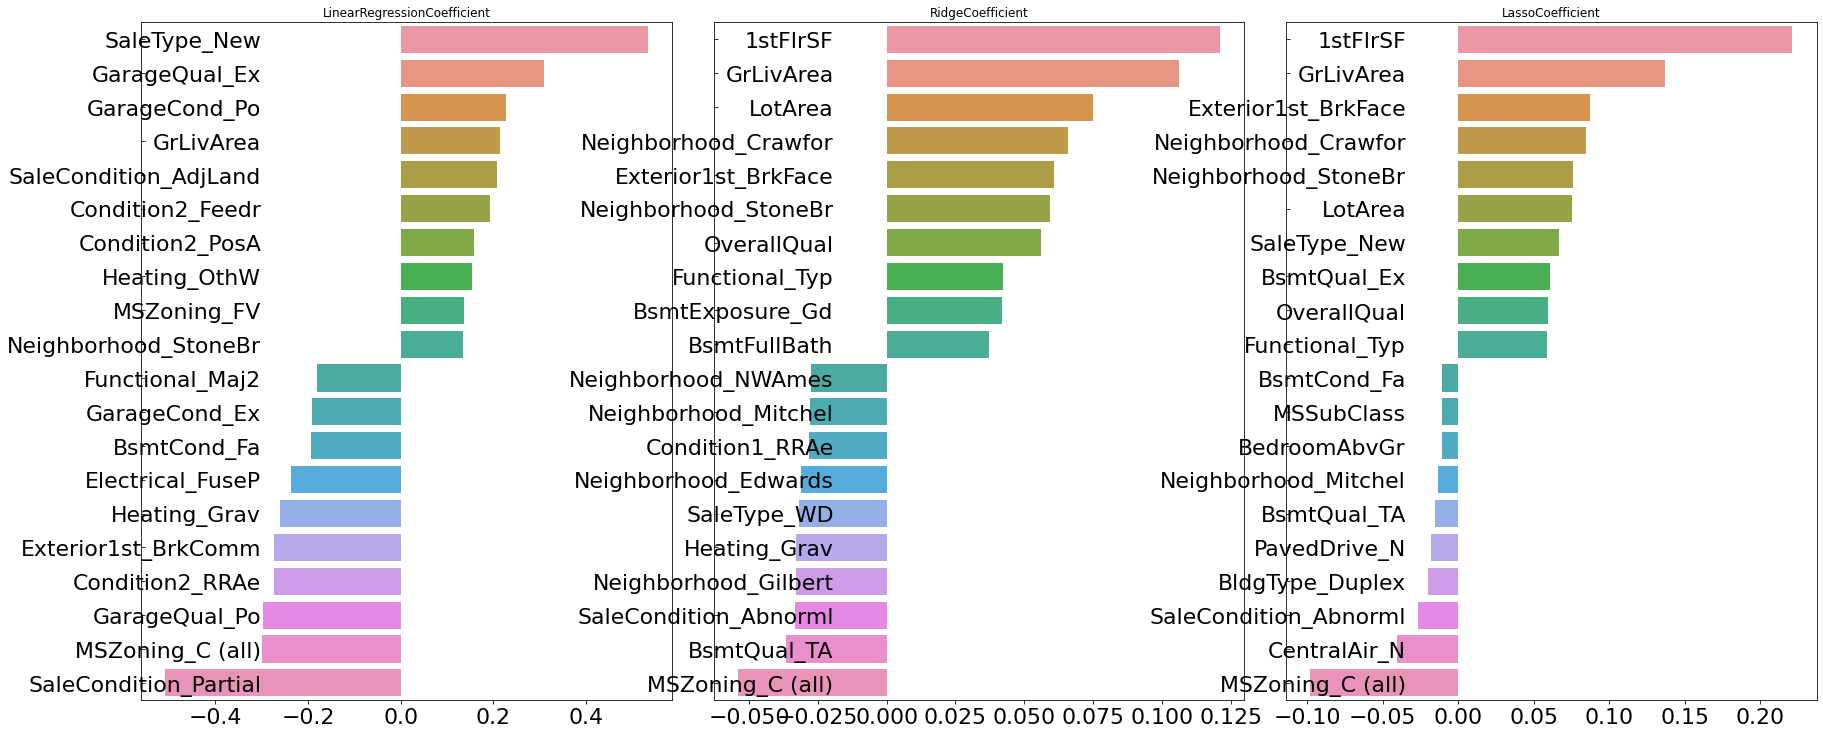

In [64]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
rid_reg = Ridge(alpha=20)
rid_reg.fit(x_train, y_train)
las_reg = Lasso(alpha=0.001)
las_reg.fit(x_train, y_train)

models = [lr_reg, rid_reg, las_reg]
get_rmses(models)

visualize_coef(models)

# XGBoost modeling

In [76]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
# colsample_bytree : feature들 중 40%만 적용
# reg_lambda : L2 norm사용(값이 클수록 파라미터에 대한 강도 높음)
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05,
                      num_leaves=4, subsample=0.6,
                      colsample_bytree=0.4, reg_lambda=10,
                      n_jobs=-1)
best_xgb = get_best_params(xgb_reg, xgb_params)

[16:09:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:09:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:09:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:09:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:09:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:09:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor 교차검증 후 최고 평균 RMSE:0.1227
최적의 파라미터값:{'n_estimators': 1000}


In [77]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05,
                        num_leaves=4, subsample=0.6,
                        colsample_bytree=0.4, reg_lambda=10,
                        n_jobs=-1)
best_lgbm = get_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 교차검증 후 최고 평균 RMSE:0.1205
최적의 파라미터값:{'n_estimators': 1000}


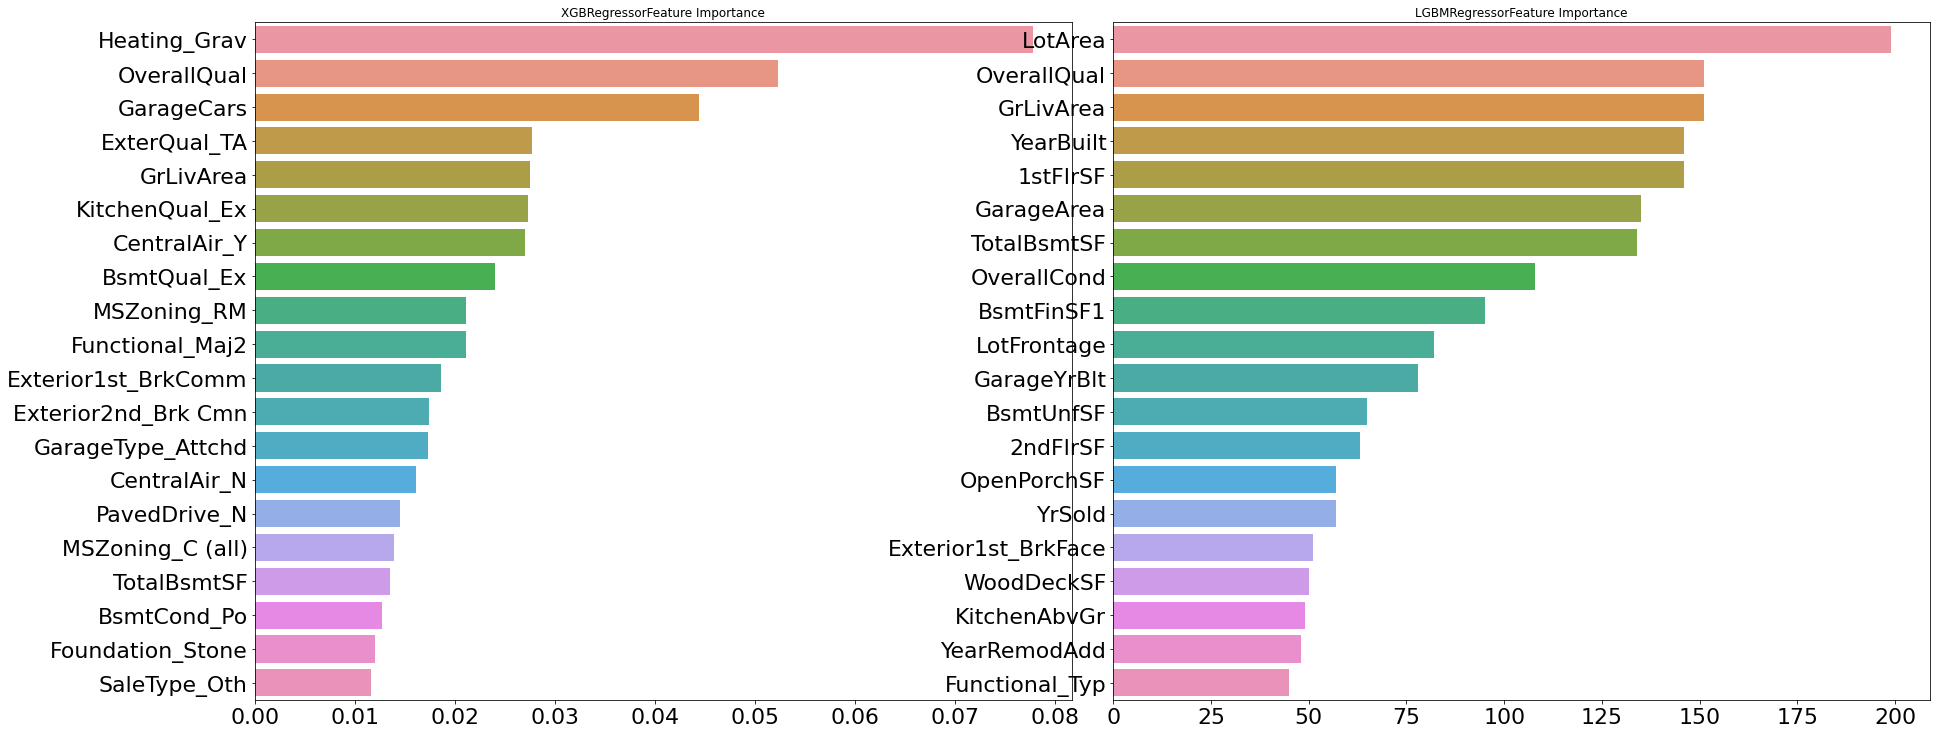

In [78]:
# Tree기반의 알고리즘에서 feature_importance를 출력
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values,
                               index=x_feature.columns)
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=2)
    fig.tight_layout()
    
    for axs_num, model in enumerate(models):
        ftr_top20 = get_top_features(model)
        axs[axs_num].set_title(model.__class__.__name__+'Feature Importance')
        for label in (axs[axs_num].get_xticklabels() + axs[axs_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index, ax=axs[axs_num])

models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)

In [79]:
# 개별 모델들의 예측값들에 가중치를 주어 평균값으로 혼합을 시킴
# 혼합시킨 데이터들도 최종 예측해보기
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print(f"{key}모델의 RSME : {rmse:.4f}")

#개별 모델 학습
rid_reg = Ridge(alpha=8)
rid_reg.fit(x_train, y_train)
las_reg = Lasso(alpha=0.001)
las_reg.fit(x_train, y_train)

# array로 반환
rid_pred = rid_reg.predict(x_test)
las_pred = las_reg.predict(x_test)
# 각 예측값에 가중치 주기
# array 형태에서 각 요소끼리 연산
pred = 0.4 * rid_pred + 0.6 * las_pred
preds = {'최종 혼합':pred,
       'Ridge': rid_pred,
       'Lasso': las_pred}
get_rmse_pred(preds)

최종 혼합모델의 RSME : 0.1117
Ridge모델의 RSME : 0.1151
Lasso모델의 RSME : 0.1114


In [80]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(x_train, y_train)
lgbm_reg.fit(x_train, y_train)
xgb_pred = xgb_reg.predict(x_test)
lgbm_pred = lgbm_reg.predict(x_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}
        
get_rmse_pred(preds)

[16:16:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
최종 혼합모델의 RSME : 0.1156
XGBM모델의 RSME : 0.1158
LGBM모델의 RSME : 0.1194


# Stacking modeling(using CV)
- 지금까지 한 회귀모델과 회귀트리 모델 Stacking 하기

In [84]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 모델 내부에서 이루어지는 프로세스
def get_stacking_base_datasets(model, x_train_n, y_train_n, x_test_n, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    # 추후에 최종 메타 모델이 학습할 학습, 테스트 데이터 shape 만들어 놓기
    # Train원본 데이터 내에서 Fold별로 행에 이어 붙임
    train_fold_pred = np.zeros((x_train_n.shape[0], 1))
    # Train원본 데이터 내에서 개별적으로 예측한 반환 값들을 이 array에다가 열로 이어 붙임
    test_pred = np.zeros((x_test_n.shape[0], n_folds))
    print(model.__class__.__name__, 'model 시작')
    
    for folder_counter, (train_idx, valid_idx) in enumerate(kf.split(x_train_n)):
        print(f'Fold set :{folder_counter}')
        x_tr = x_train_n[train_idx]
        y_tr = y_train_n[train_idx]
        x_te = x_train_n[valid_idx]
        
        model.fit(x_tr, y_tr)
        # 검증 데이터로 예측한 결과값을 fold별 index에다가 행으로 이어붙이기(2차원으로 변환)
        train_fold_pred[valid_idx, :] = model.predict(x_te).reshape(-1,1)
        # Train원본 데이터 내에서 개별적으로 예측한 값들을 array에 열로 이어붙이기
        test_pred[:, folder_counter] = model.predict(x_test_n)
    # 개별적으로 예측한 값들 평균값으로 집계한 후 2차원으로 변환
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    return train_fold_pred, test_pred_mean

In [86]:
# 위에서 정의해준 함수내부에서 array형태로 돌아가야하기 때문에 array형태로 반환
x_train_n = x_train.values
x_test_n = x_test.values
y_train_n = y_train.values

rid_train, rid_test = get_stacking_base_datasets(rid_reg, x_train_n, y_train_n, x_test_n, 5)
las_train, las_test = get_stacking_base_datasets(las_reg, x_train_n, y_train_n, x_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, x_train_n, y_train_n, x_test_n, 5)
lgb_train, lgb_test = get_stacking_base_datasets(lgbm_reg, x_train_n, y_train_n, x_test_n, 5)

Ridge model 시작
Fold set :0
Fold set :1
Fold set :2
Fold set :3
Fold set :4
Lasso model 시작
Fold set :0
Fold set :1
Fold set :2
Fold set :3
Fold set :4
XGBRegressor model 시작
Fold set :0
[16:36:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold set :1
[16:36:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold set :2
[16:36:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold set :3
[16:37:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold set :4
[16:37:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
LGBMRegressor model 시작
Fold set :0
Fold set :1
Fold set :2
Fold set :3
Fold set :4


In [88]:
# 개별모델이 도출한 train, test 데이터 Stacking시키기(열로 이어붙이기)
stack_final_x_train = np.concatenate((rid_train, las_train,
                                     xgb_train, lgb_train), axis=1)
stack_final_x_test = np.concatenate((rid_test, las_test,
                                    xgb_test, lgb_test), axis=1)

# 최종 메타모델은 Lasso Regression으로
meta_model = Lasso(alpha=0.0005)
# 학습하고 평가할 때 y값들은 원본 데이터의 y값으로 해야함!
meta_model.fit(stack_final_x_train, y_train)
stack_preds = meta_model.predict(stack_final_x_test)
mse = mean_squared_error(y_test, stack_preds)
rmse = np.sqrt(mse)
print(f"최종 스태킹 모델 RMSE: {rmse:.4f}")

최종 스태킹 모델 RMSE: 0.1116
